In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    FOLDERNAME = "Work/Assignment1"

    work_dir = f'/content/drive/My Drive/{FOLDERNAME}'
except ImportError:
    work_dir = './'

import sys
sys.path.append(work_dir)

import os
data_dir = os.path.join(work_dir, 'data')

Mounted at /content/drive


# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the Instructions.docx.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
# Run some setup code for this notebook.

import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Download and construct the CIFAR-10 dataset.
train_dataset = torchvision.datasets.CIFAR10(root=data_dir,
                                             train=True,
                                             transform=transforms.ToTensor(),
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root=data_dir,
                                             train=False,
                                             transform=transforms.ToTensor(),
                                             download=True)

print(f'CIFAR-10 training dataset has {len(train_dataset)} images, and test dataset has {len(test_dataset)} images.')

X_train = torch.stack([x for x, _ in train_dataset]) # (num_train, c, h, w)
y_train = torch.tensor(train_dataset.targets) # (num_train,)
X_test = torch.stack([x for x, _ in test_dataset]) # (num_test, c, h, w)
y_test = torch.tensor(test_dataset.targets) # (num_test,)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 training dataset has 50000 images, and test dataset has 10000 images.
Training data shape:  torch.Size([50000, 3, 32, 32])
Training labels shape:  torch.Size([50000])
Test data shape:  torch.Size([10000, 3, 32, 32])
Test labels shape:  torch.Size([10000])


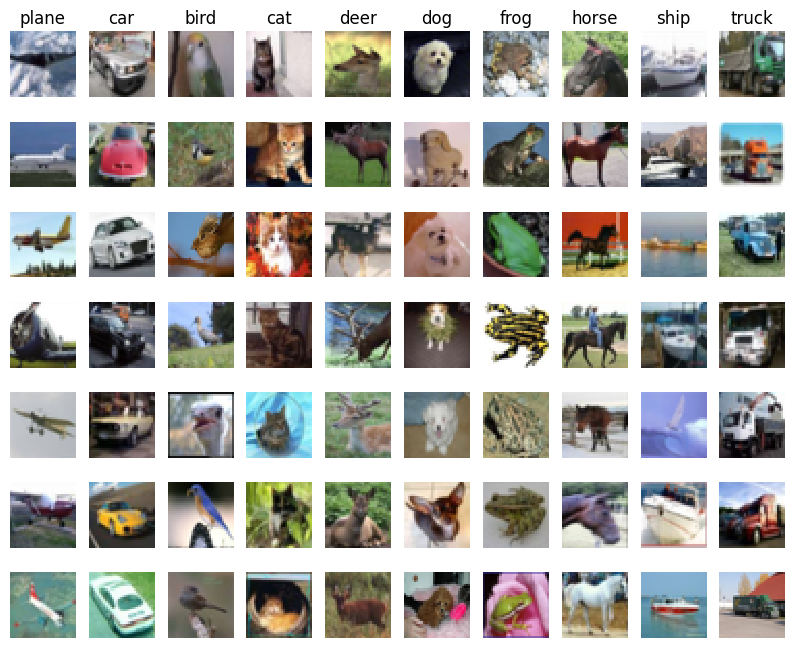

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].permute(1, 2, 0).numpy())
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  torch.Size([49000, 3, 32, 32])
Train labels shape:  torch.Size([49000])
Validation data shape:  torch.Size([1000, 3, 32, 32])
Validation labels shape:  torch.Size([1000])
Test data shape:  torch.Size([1000, 3, 32, 32])
Test labels shape:  torch.Size([1000])


In [ ]:
# Preprocessing: reshape the image data into rows
X_train = torch.reshape(X_train, (X_train.shape[0], -1))
X_val = torch.reshape(X_val, (X_val.shape[0], -1))
X_test = torch.reshape(X_test, (X_test.shape[0], -1))
X_dev = torch.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('Dev data shape: ', X_dev.shape)

Training data shape:  torch.Size([49000, 3072])
Validation data shape:  torch.Size([1000, 3072])
Test data shape:  torch.Size([1000, 3072])
Dev data shape:  torch.Size([500, 3072])


tensor([0.5123, 0.5100, 0.5136, 0.5156, 0.5180, 0.5207, 0.5227, 0.5248, 0.5271,
        0.5288])


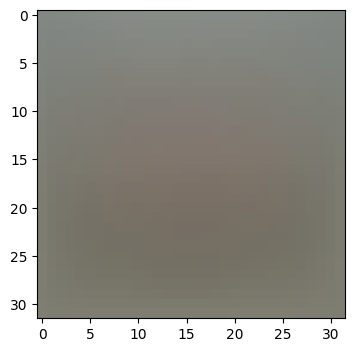

torch.Size([49000, 3073]) torch.Size([1000, 3073]) torch.Size([1000, 3073]) torch.Size([500, 3073])


In [ ]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = torch.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((3,32,32)).permute(1, 2, 0).numpy()) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = torch.hstack([X_train, torch.ones((X_train.shape[0], 1))])
X_val = torch.hstack([X_val, torch.ones((X_val.shape[0], 1))])
X_test = torch.hstack([X_test, torch.ones((X_test.shape[0], 1))])
X_dev = torch.hstack([X_dev, torch.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `src/classifiers/linear_svm.py`.

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function.

In [ ]:
# Evaluate the naive implementation of the loss we provided for you:
from src.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = torch.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.001182


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [ ]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from src.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 0.047684 analytic: 0.018655, relative error: 4.375933e-01
numerical: -0.047684 analytic: 0.069415, relative error: 1.000000e+00
numerical: 0.000000 analytic: -0.067248, relative error: 1.000000e+00
numerical: 0.047684 analytic: 0.054872, relative error: 7.009467e-02
numerical: 0.000000 analytic: 0.015596, relative error: 1.000000e+00
numerical: 0.000000 analytic: -0.021217, relative error: 1.000000e+00
numerical: 0.000000 analytic: -0.008215, relative error: 1.000000e+00
numerical: -0.047684 analytic: -0.045953, relative error: 1.848486e-02
numerical: -0.095367 analytic: -0.086915, relative error: 4.637245e-02
numerical: 0.047684 analytic: -0.013322, relative error: 1.000000e+00
numerical: 0.000000 analytic: 0.034658, relative error: 1.000000e+00
numerical: 0.047684 analytic: 0.086880, relative error: 2.912832e-01
numerical: -0.095367 analytic: -0.181212, relative error: 3.103792e-01
numerical: 0.095367 analytic: 0.141479, relative error: 1.946890e-01
numerical: -0.190735 an

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *The SVM loss uses the hinge function
𝑓
(
𝑥
)
=
max
⁡
(
0
,
𝑥
)
f(x)=max(0,x), which is non-differentiable at
𝑥
=
0
x=0. In one dimension, at
𝑥
=
0
x=0 the left derivative is 0 and the right derivative is 1, so a gradient check may give inconsistent results around that point. Increasing the margin (delta) makes it less likely for inputs to fall exactly at the non-differentiable point, reducing such discrepancies.*  


In [ ]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from src.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.001182e+00 computed in 0.606191s
Vectorized loss: 9.001168e+00 computed in 0.004562s
difference: 0.000013


In [ ]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = torch.norm(grad_naive - grad_vectorized, p='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.857964s
Vectorized loss and gradient: computed in 0.005360s
difference: 0.000013


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `src/classifiers/linear_classifier.py`.

In [ ]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from src.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()

# To accelerate, put data to a CUDA GPU device if you have, e.g. the T4 GPU on Google Colab.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
X_train = X_train.to(device)
y_train = y_train.to(device)

loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 781.348877
iteration 100 / 1500: loss 292.422485
iteration 200 / 1500: loss 113.010490
iteration 300 / 1500: loss 47.165665
iteration 400 / 1500: loss 23.004734
iteration 500 / 1500: loss 14.138402
iteration 600 / 1500: loss 10.884284
iteration 700 / 1500: loss 9.690751
iteration 800 / 1500: loss 9.252794
iteration 900 / 1500: loss 9.092189
iteration 1000 / 1500: loss 9.032685
iteration 1100 / 1500: loss 9.011067
iteration 1200 / 1500: loss 9.003284
iteration 1300 / 1500: loss 9.000787
iteration 1400 / 1500: loss 8.999346
That took 4.210683s


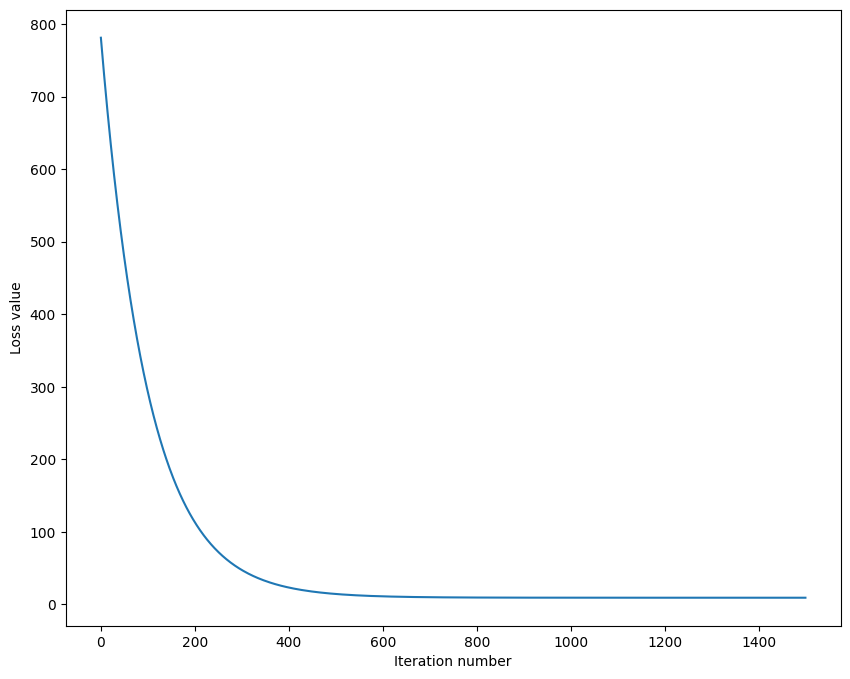

In [ ]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (torch.mean((y_train == y_train_pred).float()), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (torch.mean((y_val == y_val_pred).float()), ))

training accuracy: 0.246918
validation accuracy: 0.257000


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
# Here we try a finer grid along with a smaller batch size and more iterations.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        # Increase iterations and use a smaller batch size for more fine-grained updates.
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,num_iters=1500)
        # Evaluate on the training set.
        train_pred = svm.predict(X_train)
        train_accuracy = (train_pred == y_train).float().mean().item()
        # Evaluate on the validation set.
        val_pred = svm.predict(X_val)
        val_accuracy = (val_pred == y_val).float().mean().item()
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)


lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.246327 val accuracy: 0.260000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.376100 val accuracy: 0.370000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.100265 val accuracy: 0.087000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.370000


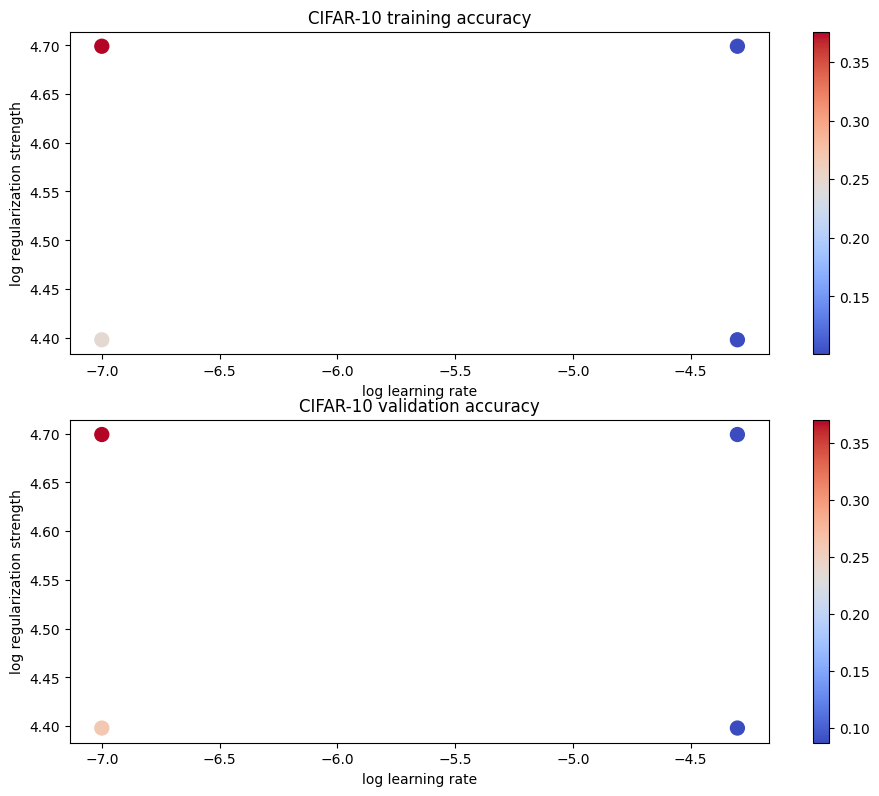

In [ ]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
#Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = torch.mean((y_test == y_test_pred).float())
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.373800


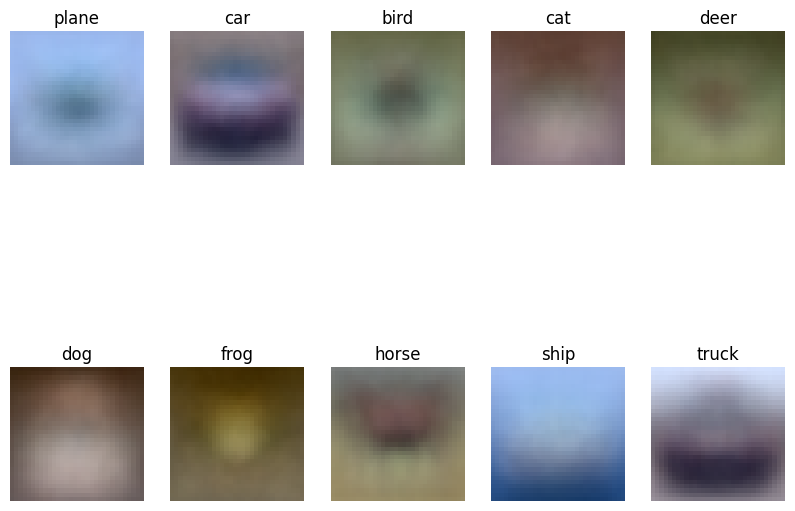

In [ ]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.cpu().numpy()  # Put it back to CPU for visualization if you have put it to GPU
w = w.reshape(3, 32, 32, 10).transpose(1, 2, 0, 3)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ *They typically appear as blurry or low-resolution outlines that capture broad color and shape cues for each class. Because the SVM is linear, it can only learn a single weight map for each class, so these filters highlight the most discriminative color/texture patterns (e.g., greenish regions for “frog” or red hues for “car”) that help separate each class from the others.*  
